In [1]:
! pip install arch


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
! pip install numpy 


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
! pip install matplotlib


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
! pip install scikit-learn


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Importation des librairies

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from arch.univariate import GARCH, ZeroMean
import pandas as pd 
from math import log 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import statsmodels.api as sm

## Echantillonnage des données simulées selon un modèle GARCH(1,1)  

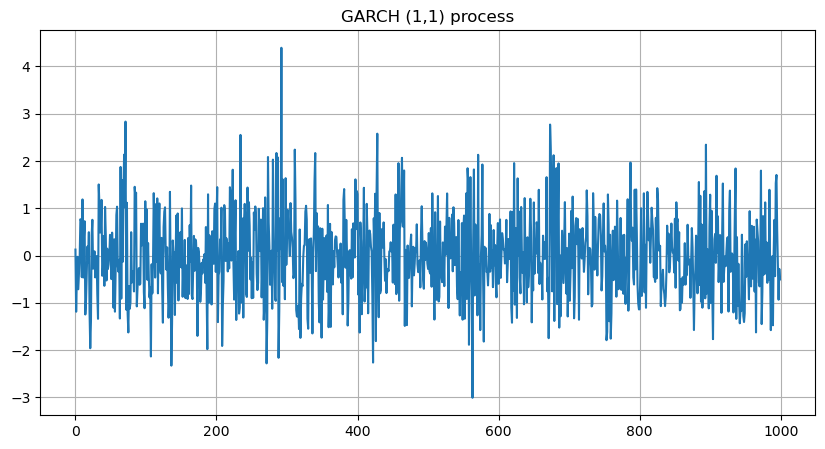

In [6]:

np.random.seed(12345)

n = 1000        # n le nombre d'observations à générer
n1 = 100        # n1 est le nombre des observations premières qu'on supprime de l'échantillon 
n2 = n + n1     # n2 est le nombre de simulations total

# Les paramètres de GARCH(1,1)
omega = 0.1
alpha = 0.2   
beta = 0.7

errors = np.random.normal(0,1,n2) 
h2 = np.zeros(n2)
r = np.zeros(n2)
h2[0] = omega

for i in range(1,n2-1): 
    h2[i] = omega + alpha*h2[i-1]*errors[i-1]**2 + beta*h2[i-1]
    r[i] = np.sqrt(h2[i])*errors[i]

h = h2[n1-1:-1]
y = r[n1-1:-1]    # On élimine les premières observations

plt.figure(figsize=(10, 5))
plt.title('GARCH (1,1) process')
x = range(n) 
plt.plot(x,y)
plt.grid(True)
plt.show()

## Récupération des données réelles 

On calcule la transformation logarithmique du taux de change Euro/US Dollar journalier sur la période entre 24/04/2021 et 24/04/2024.

Source : https://www.investing.com/currencies/eur-usd-historical-data

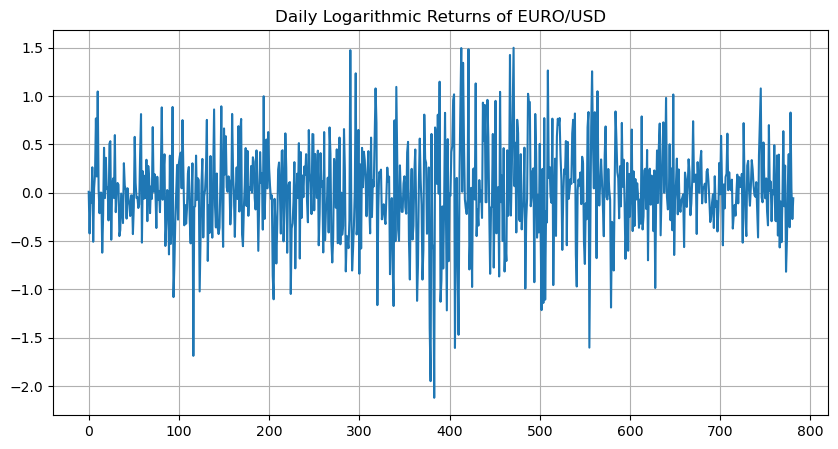

In [7]:
Prix = pd.read_csv("EUR_USD Historical Data.csv")['Price']
r = []
for i in range(len(Prix)-1) :
    r.append(log(Prix[i+1]/ Prix[i])*100)

plt.figure(figsize=(10, 5))
plt.title('Daily Logarithmic Returns of EURO/USD')
x = range(len(r)) 
plt.plot(x,r)
plt.grid(True)
plt.show()


## Metropolis sampler

Pour répondre à la question, nous implémentons un random walk Metropolis sampler qui cible la distribution à posteriori des paramètres d'un GARCH(1,1). Pour ce faire, nous suivrons les étapes suivantes : 

1. Implémentation de la distribution à priori (priors) : nous avons choisi une loi normale tronquée pour chaque paramètre wi comme dans l'article. En effet, les para
   Nous avons fait le choix de prendre de grandes variances pour que la distribution à posteriori reflète essentiellement les données et non pas nos propres croyances. De plus, w1, w2 et w3 sont supposées indépendants.

2. Implémentation de la vraisemblance 
3. Déduction de la distribution à posteriori

In [8]:
# 1. Distribution a priori de (w1, w2, w3)

def prior(omega, var):
    """
        omega (list): le vecteur des paramètres [w1,w2,w3]
        var (list): le vecteur des variances des lois normales
    """
    P = 1
    for i in range (len(omega)):
        if omega[i] > 0 :
            P = P* np.exp(-0.5 * (omega[i]**2/var[i]))
        else : 
            return 0
    return P


# 2. Fonction de log-vraisemblance conditionnelle du modèle GARCH log(L(r/w))

def likelihood(returns, omega):
    T = 100
    h = np.zeros(T)
    h[0] = 1.4128118384007489 # à la première valeur de h on associe la variance des taux d'intérêt.
    
    for t in range(1, T):
        h[t] = omega[0] + omega[2] * h[t-1] + omega[1] * (returns[t-1] ** 2)
    L = np.prod((10/np.sqrt(h)) * np.exp(-0.5*(np.array(returns[:100])**2)/h))
    return L




# 3. Distribution à posteriori

def posterior (returns, omega, var) :
    return prior (omega,var) * likelihood(returns,omega)

4. Echantionnage avec l'algorithme Metropolis-Hasting  


In [9]:

# Probabilité de transition de x vers y et de y vers x 

def q(x, y, sigma):
    if np.linalg.det(sigma) == 0 :
        return 1
    else :
        sigma_inv = np.linalg.inv(sigma)
        q = (1 / (np.sqrt((2 * np.pi)**3 * np.linalg.det(sigma)))) * np.exp(-0.5 * np.dot(np.dot((y - x).T, sigma_inv), (y - x)))
        return q

def metropolis (returns, omega_current, n_iter, var, c):
    
    # On initialise le nombre d'omegas acceptés dans l'algorithme
    j = 0 

    # omega_matrix est la matrice de notre échantillon, on stocke la valeur initiale du vecteur omega
    omega_matrix = omega_current 

    # c*sigma est un estimateur de la matrice de variance-covariance de la distribution à posteriori
    # On initialise sigma par la matrice identité, elle sera actualisé par la méthode 'adaptive MCMC'
    sigma = np.eye(3) 
    np.random.seed(12)
    for i in range (0,n_iter):

        # Proposer un nouveau jeu de paramètres omega_n qui correspond à Y et omega_current c'est Xn-1.
        omega_n = omega_current + abs(np.random.multivariate_normal(np.array([0,0,0]), sigma*c))

        # Calcul de r(x, y) ; Dans notre cas, q_ratio = 1
        r = posterior (returns, omega_n, var)/posterior (returns, omega_current, var)

        # Affectation de la valeur de Xn : Xn = Y avec une proba = min (1,r)
        if np.random.uniform() < min(1,r) : 
            omega_current = omega_n 
            j = j + 1

        # Ajout du nouveau vecteur des omégas à notre matrice 
        omega_matrix = np.vstack((omega_matrix, omega_current)) 

        # On centre notre échantillon
        mean_X = np.mean(omega_matrix, axis=0)
        centered_omega = omega_matrix - mean_X

        # Actualisation de la matrice de variance-covariance empirique sigma avec 'adaptive MCMC'
        sigma = np.cov(centered_omega, rowvar=False)
    
    # j/n_iter est le taux d'acceptation et omega_matrix est notre échantillon pour une valeur donnée de c
    return j/n_iter, centered_omega, np.mean(centered_omega, axis=0)


def c_optimal (returns, omega_current, n_iter,var, a, b):

    # T est une liste qui stocke les taux d'acceptation pour plusieurs valeurs de c
    T=[] 

    # on se donne un certain nombre de valeurs de c dans un intervalle [a,b]
    C = np.linspace(a,b,1000) 
    
    for c in C :
        taux = metropolis (returns, omega_current, n_iter, var, c)[0]
        T.append (taux)

    plt.plot(C,T)
    plt.show()
    return T


In [ ]:
## Pour les données simulées y
J1 = c_optimal (y, np.array([1,1,1]), 100000,[1,1,1], 0.001, 1)
# En regardant le taux d'acceptance pour différentes valeurs de c, la valeur de c qui donne un taux d'acceptance de l'ordre de 0.25 est 
# c* = 0.0005

## Pour les données réelles r
J2 = c_optimal (r, np.array([1,1,1]), 100000,[1,1,1], 0.001, 1)
# La valeur optimale de c est c* = 0.0005

In [10]:
def metropolis2 (returns, omega_current, n_iter, var, sigma):
    
    j = 0 

    omega_matrix = omega_current 
    np.random.seed(12)

    for i in range (0,n_iter):

        omega_n = omega_current + np.random.normal(loc=0, scale=sigma, size=3)
        
        while np.any(omega_n <=0 ) :
            omega_n = omega_current + np.random.normal(loc=0, scale=sigma, size=3)
        r = posterior (returns, omega_n, var)/posterior (returns, omega_current, var)

        if np.random.uniform() < min(1,r) : 
            omega_current = omega_n 
            j = j + 1
        omega_matrix = np.vstack((omega_matrix, omega_current)) 
    
    return j/n_iter, omega_matrix


def sigma_optimal (returns, omega_current, n_iter,var, a, b):

    # T est une liste qui stocke les taux d'acceptation pour plusieurs valeurs de c
    T=[] 

    # on se donne un certain nombre de valeurs de c dans un intervalle [a,b]
    S = np.linspace(a,b,100) 
    
    for sigma in S :
        taux = metropolis2 (returns, omega_current, n_iter, var, sigma)[0]
        T.append (taux)

    plt.plot(S,T)
    plt.show()
    return T

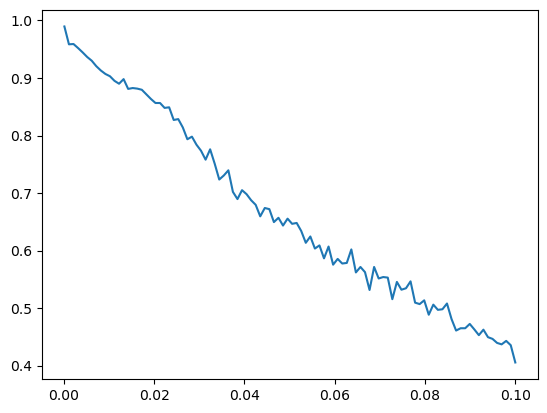

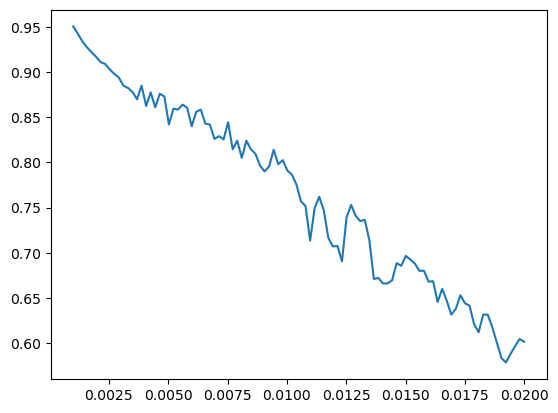

In [14]:
omega_current = np.array([0.05,0.244,0.598])
var = [100,100,100]
n_iter = 10000

T_sim = sigma_optimal (y, omega_current, 2000 ,var, 0.0001, 0.1)
T_reel = sigma_optimal (r, omega_current, 2000 ,var, 0.001, 0.02)

In [15]:
T1_min = min(T_sim) 
i_sim = T_sim.index(T1_min)
P1 = np.linspace(0.0001,0.1,100)
Sigma_opt_sim = P1[i_sim]
print('Pour les données simulées : \n La valeur de sigma optimale est ' + str(Sigma_opt_sim) + ".\n Elle donne un taux d'acceptation de "+ str(T1_min))

T2_min = min(T_reel) 
i_reel = T_reel.index(T2_min)
P2 = np.linspace(0.0001,0.02,100)
Sigma_opt_reel = P2[i_reel]
print("Pour les données réelles : \n La valeur de sigma optimale est " + str(Sigma_opt_reel) + ".\n Elle donne un taux d'acceptation de "+ str(T2_min))



Pour les données simulées : 
 La valeur de sigma optimale est 0.1.
 Elle donne un taux d'acceptation de 0.4055
Pour les données réelles : 
 La valeur de sigma optimale est 0.019195959595959596.
 Elle donne un taux d'acceptation de 0.5785


## Ordinary MCMC

In [17]:
omega_current = np.array([0.05,0.244,0.598])
var = [100,100,100]
n_iter = 3000

echant_sim = metropolis2 (y, omega_current, n_iter, var, Sigma_opt_sim)[1]
accep_rate_sim = metropolis2 (y, omega_current, n_iter, var, Sigma_opt_sim)[0]

echant_reel = metropolis2 (r, omega_current, n_iter, var, Sigma_opt_reel)[1]
accep_rate_reel = metropolis2 (r, omega_current, n_iter, var, Sigma_opt_reel)[0]

In [293]:
print (accep_rate_sim)
print (accep_rate_reel)


0.4206666666666667
0.8223333333333334


In [ ]:
omega_current = np.array([0.05,0.244,0.598])
var = [100,100,100]
n_iter = 2000

c_opt_sim = 1/5000
echant_sim = metropolis (y, omega_current, n_iter, var, c_opt_sim)[1]
accep_rate_sim = metropolis (y, omega_current, n_iter, var, c_opt_sim)[0]

c_opt_reel = 1/5000
echant_reel = metropolis (r, omega_current, n_iter, var, c_opt_reel)[1]
accep_rate_reel = metropolis (r, omega_current, n_iter, var, c_opt_reel)[0]


## Visualisation de l'évolution des paramètres

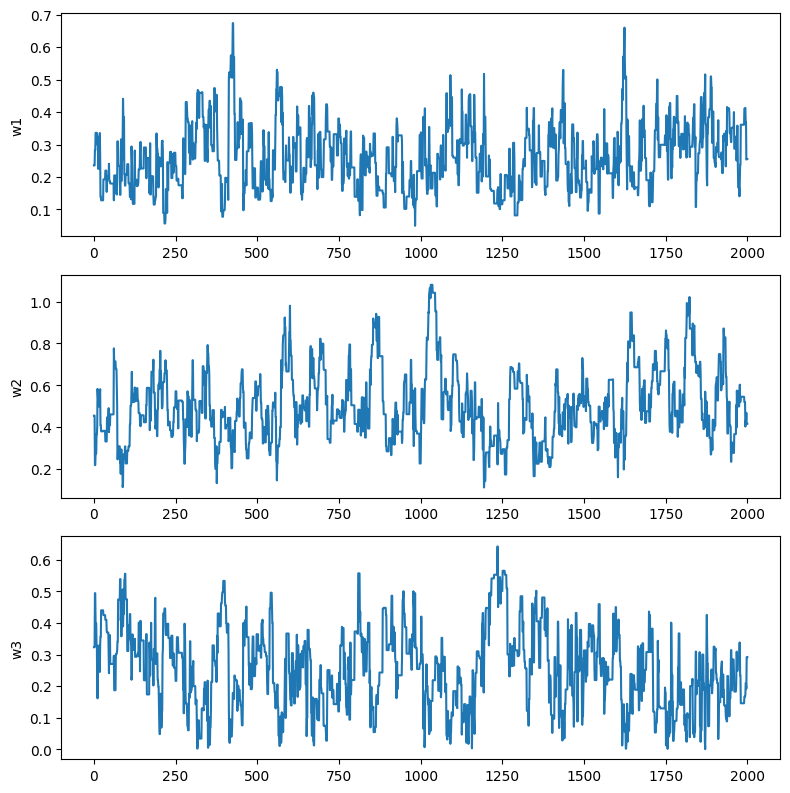

In [295]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

axs[0].plot(range(2001), echant_sim[1000:, 0])
axs[0].set_ylabel('w1')
axs[1].plot(range(2001), echant_sim[1000:, 1])
axs[1].set_ylabel('w2')
axs[2].plot(range(2001), echant_sim[1000:, 2])
axs[2].set_ylabel('w3')
plt.tight_layout()
plt.show()

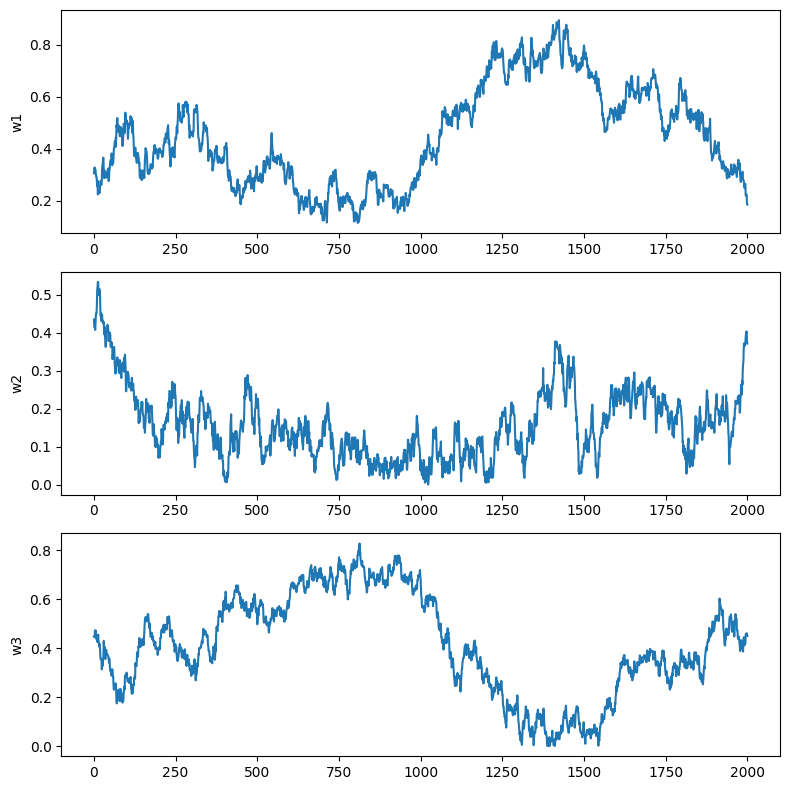

In [296]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
axs[0].plot(range(2001), echant_reel[1000:, 0])
axs[0].set_ylabel('w1')
axs[1].plot(range(2001), echant_reel[1000:, 1])
axs[1].set_ylabel('w2')
axs[2].plot(range(2001), echant_reel[1000:, 2])
axs[2].set_ylabel('w3')
plt.tight_layout()
plt.show()

In [ ]:
def confidence_intervals(mean, se, z_value=1.96):
    lower_bound = mean - z_value * se
    upper_bound = mean + z_value * se
    return lower_bound, upper_bound

def stat_descrip(echant):
    # Calcul des moyennes
    mean_o1 = np.mean(echant[:,0])
    mean_o2 = np.mean(echant[:,1])
    mean_o3 = np.mean(echant[:,2])

    # Calcul des erreurs standards empiriques
    se_o1 = np.std(echant[:,0]) / np.sqrt(len(echant[:,0]))
    se_o2 = np.std(echant[:,1]) / np.sqrt(len(echant[:,1]))
    se_o3 = np.std(echant[:,2]) / np.sqrt(len(echant[:,2]))

    # Calcul des intervalles de confiance à 95%
    ci_o1 = confidence_intervals(mean_o1, se_o1)
    ci_o2 = confidence_intervals(mean_o2, se_o2)
    ci_o3 = confidence_intervals(mean_o3, se_o3)

    # Affichage des résultats
    print("La moyenne de omega1 est autour :", mean_o1)
    print("L'intervalle de confiance de omega1 est donné par :", ci_o1)
    print("La moyenne de omega2 est autour :", mean_o2)
    print("L'intervalle de confiance de omega1 est donné par :", ci_o2)
    print()
    print("La moyenne de omega3 est autour :", mean_o3)
    print("L'intervalle de confiance de omega3 est donné par :", ci_o3)

stat_descrip(echant_sim)
stat_descrip(echant_reel)


## ZV-MCMC : First Order Control Variates

In [18]:
def calcul_z(omega_1, omega_2, omega_3, h, r, sigma):
    T = len(h)
    z_1 = omega_1 / (2 * sigma ** 2)
    z_2 = omega_2 / (2 * sigma ** 2)
    z_3 = omega_3 / (2 * sigma ** 2)
    
    for t in range(1,T):
        dht_domega1 = (1 - omega_3 ** (t-1)) / (1 - omega_3)
        z_1 += 0.25 * (1/h[t]) * dht_domega1 - int((r[t] ** 2 / h[t]**2)) * dht_domega1
        dht_domega2 = np.array([np.sum([w_i**(t-2-i) * r[i]**2 for i in range(t-1)]) for w_i in omega_2])
        z_2 += 0.25 * (1/h[t]) * dht_domega2 - r[t] ** 2 / h[t]**2 * dht_domega2
        dht_domega3 = np.array([np.sum([w_i**(t-2-i) * h[i]**2 for i in range(t-1)]) for w_i in omega_3])
        z_3 += 0.25 * (1/h[t]) * dht_domega3 - (r[t] ** 2 / h[t]) * dht_domega3
    return np.column_stack([z_1, z_2, z_3])

In [42]:
z11 = calcul_z(echant_sim[:,0], echant_sim[:,1], echant_sim[:,2], h[:100], y[:100], 100)

In [72]:
def z1_i(r, h, x, i):
    return  (1-x[2]**(i))/(1-x[2]) * (-(0.5/h) + (0.5 * r**2)/(h**2))

def z1(x , data, h_initial, var):
    Z = 0
    h = h_initial 

    for i in range(1, len(data)):
        h = x[0] + x[1] * data[i-1]**2 + x[2] * h
        Z += z1_i(data[i],h,x,i)

    return -1/2 * (- x[0]/var + Z)

In [70]:
def z2_i(r,h,r_lag,h_lag, x, i,h_prime):
    return  (h_prime) * (-(0.5/h) + (0.5 * r**2)/(h**2))

def z2(x , data, h_initial, var):
    Z = 0
    h_t = h_initial
    h_prime = 0 #initial derivatves of h wrt alpha (x[1])
    
    for i in range(1, len(data)):
        h = h_t
        h_prime = data[i-1]**2 + x[2]*h_prime
        h_t = x[0] + x[1] * data[i-1]**2 + x[2] * h
        Z += z2_i(data[i],h_t,data[i-1],h,x,i,h_prime)

    return -1/2 * (- x[1]/var + Z)

In [71]:
def z3_i(r,h,r_lag,h_lag, x, i,h_prime):
    return  (h_prime) * (-(0.5/h) + (0.5 * r**2)/(h**2))

def z3(x , data, h_initial, var):
    Z = 0
    h_t = h_initial
    h_prime = 0 #initial derivatves of h wrt beta (x[2])
    
    for i in range(1, len(data)):
        h = h_t
        h_prime = h + x[2]*h_prime
        h_t = x[0] + x[1] * data[i-1]**2 + x[2] * h
        Z += z3_i(data[i],h_t,data[i-1],h,x,i,h_prime)

    return -1/2 * (- x[2]/var + Z)


In [75]:
def CV_2(x,var):
    gradient1 = list(map(lambda x: z1(x, r, 0, var), x))
    gradient2 = list(map(lambda x: z2(x,r,0, var), x))
    gradient3 = list(map(lambda x: z3(x,r, 0, var), x))
    return  np.column_stack([gradient1,gradient2,gradient3])

In [76]:
# Les variables de contrôle pour les données simulées

var_sim = np.var(y[:100], ddof=0)
CV1_sim = calcul_z(echant_sim[:,0], echant_sim[:,1], echant_sim[:,2], h[:100], y[:100], var_sim)
CV1_sim_2 = CV_2(echant_sim,var_sim)


# Les variables de contrôle pour les données réelles 

omega1 = echant_reel[:,0].mean()
omega2 = echant_reel[:,1].mean()
omega3 = echant_reel[:,2].mean()

h_reel = np.zeros(len(r[:100])) 

# On estime la variance conditionnelle des données réelles en estimant les omegas par les moyennes empiriques de l'échantillon généré
for t in range(1,len(r[:100])) :
    h_reel[t] = omega1 + omega2 * h_reel[t-1] + omega3 * r[t-1]**2

var_reel = np.var(r[:100], ddof=0)
CV1_reel = calcul_z(echant_reel[:,0], echant_reel[:,1], echant_reel[:,2], h_reel, r[:100], var_reel)
CV1_reel_2 = CV_2(echant_reel,var_reel)

In [51]:
def enlever_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)

    IQR = Q3 - Q1

    # Définition des limites
    limite_inferieure = Q1 - 10 * IQR
    limite_superieure = Q3 + 10 * IQR
    donnees_sans_outliers = np.copy(data)
    for i in range(1, len(data)):
        if (data[i] < limite_inferieure).any() or (data[i] > limite_superieure).any():
            donnees_sans_outliers[i] = donnees_sans_outliers[i - 1]
    return donnees_sans_outliers

## Définition des omega-tildes

In [78]:

# Les variables de contrôle pour les données simulées

omega_current = np.array([0.05,0.244,0.598])
var = [100,100,100]
n_iter = 10000

omega_nv_sim = metropolis2 (y, omega_current, n_iter, var, Sigma_opt_sim)[1]
CV1_nv_sim = calcul_z(omega_nv_sim[:,0], omega_nv_sim[:,1], omega_nv_sim[:,2], h[:100], y[:100], var_sim)
CV1_nv_sim_2 = CV_2(omega_nv_sim, var_sim)


def combi_omega(k, echant_sim, CV1_sim, CV1_nv_sim):

    model = sm.OLS(echant_sim[:,k], CV1_sim) # CV1_sim = sm.add_constant(CV1_sim)
    results = model.fit(cov_type='HC3')
    coeff_opt = results.params # CV1_nv_sim1 = np.insert(CV1_nv_sim, 0, 1, axis=1)
    combi = np.dot(coeff_opt, CV1_nv_sim.transpose())
    print(results.summary())
    return combi


# ------------------------------------- Omega_1----------------------------------------------------------------
combi_omega1 = combi_omega(0, echant_sim, CV1_sim, CV1_nv_sim)
omega_tilde_1 = omega_nv_sim[:,0] - combi_omega1
omega_tilde_1ss = enlever_outliers(omega_tilde_1)

# ------------------------------------- Omega_2----------------------------------------------------------------
combi_omega2 = combi_omega(1, echant_sim, CV1_sim, CV1_nv_sim)
omega_tilde_2 = omega_nv_sim[:,1] - combi_omega2
omega_tilde_2ss = enlever_outliers(omega_tilde_2)

# ------------------------------------- Omega_3----------------------------------------------------------------
combi_omega3 = combi_omega(2, echant_sim, CV1_sim, CV1_nv_sim)
omega_tilde_3 = omega_nv_sim[:,2] - combi_omega3
omega_tilde_3ss = enlever_outliers(omega_tilde_3)


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.936
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                          1.404e+04
Date:                Sun, 28 Apr 2024   Prob (F-statistic):                        0.00
Time:                        22:31:10   Log-Likelihood:                          3792.0
No. Observations:                3001   AIC:                                     -7578.
Df Residuals:                    2998   BIC:                                     -7560.
Df Model:                           3                                                  
Covariance Type:                  HC3                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

In [79]:
combi_omega1 = combi_omega(0, echant_sim, CV1_sim_2, CV1_nv_sim_2)
omega_tilde_1 = omega_nv_sim[:,0] - combi_omega1
omega_tilde_1ss = enlever_outliers(omega_tilde_1)

# ------------------------------------- Omega_2----------------------------------------------------------------
combi_omega2 = combi_omega(1, echant_sim, CV1_sim_2, CV1_nv_sim_2)
omega_tilde_2 = omega_nv_sim[:,1] - combi_omega2
omega_tilde_2ss = enlever_outliers(omega_tilde_2)

# ------------------------------------- Omega_3----------------------------------------------------------------
combi_omega3 = combi_omega(2, echant_sim, CV1_sim_2, CV1_nv_sim_2)
omega_tilde_3 = omega_nv_sim[:,2] - combi_omega3
omega_tilde_3ss = enlever_outliers(omega_tilde_3)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.825
Model:                            OLS   Adj. R-squared (uncentered):              0.825
Method:                 Least Squares   F-statistic:                              3070.
Date:                Sun, 28 Apr 2024   Prob (F-statistic):                        0.00
Time:                        22:31:20   Log-Likelihood:                          2281.3
No. Observations:                3001   AIC:                                     -4557.
Df Residuals:                    2998   BIC:                                     -4539.
Df Model:                           3                                                  
Covariance Type:                  HC3                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

In [375]:
# Les variables de contrôle pour les données réelles

omega_current = np.array([0.05,0.244,0.598])
var = [100,100,100]
n_iter = 10000

omega_nv_reel = metropolis2 (r, omega_current, n_iter, var, Sigma_opt_reel)[1]
CV1_nv_reel = calcul_z(omega_nv_reel[:,0], omega_nv_reel[:,1], omega_nv_reel[:,2], h_reel[:100], r[:100], var_reel)

# ------------------------------------- Omega_1----------------------------------------------------------------

combi_omega1_reel = combi_omega(0, echant_reel, CV1_reel, CV1_nv_reel)
omega_tilde_1_reel = omega_nv_reel[:,1] - combi_omega1_reel
omega_tilde_1ss_reel = enlever_outliers(omega_tilde_1_reel)

# ------------------------------------- Omega_2----------------------------------------------------------------
combi_omega2_reel = combi_omega(1, echant_reel, CV1_reel, CV1_nv_reel)
omega_tilde_2_reel = omega_nv_reel[:,1] - combi_omega2_reel
omega_tilde_2ss_reel = enlever_outliers(omega_tilde_2_reel)

# ------------------------------------- Omega_3----------------------------------------------------------------
combi_omega3_reel = combi_omega(2, echant_reel, CV1_reel, CV1_nv_reel)
omega_tilde_3_reel = omega_nv_reel[:,1] - combi_omega3_reel
omega_tilde_3ss_reel = enlever_outliers(omega_tilde_3_reel)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.910
Model:                            OLS   Adj. R-squared (uncentered):              0.910
Method:                 Least Squares   F-statistic:                              9571.
Date:                Sun, 28 Apr 2024   Prob (F-statistic):                        0.00
Time:                        18:36:04   Log-Likelihood:                          1958.9
No. Observations:                3001   AIC:                                     -3912.
Df Residuals:                    2998   BIC:                                     -3894.
Df Model:                           3                                                  
Covariance Type:                  HC3                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

## Visualatisation des trajectoires des omegas après ZV-MCMC d'ordre 1

Pour les données simulées

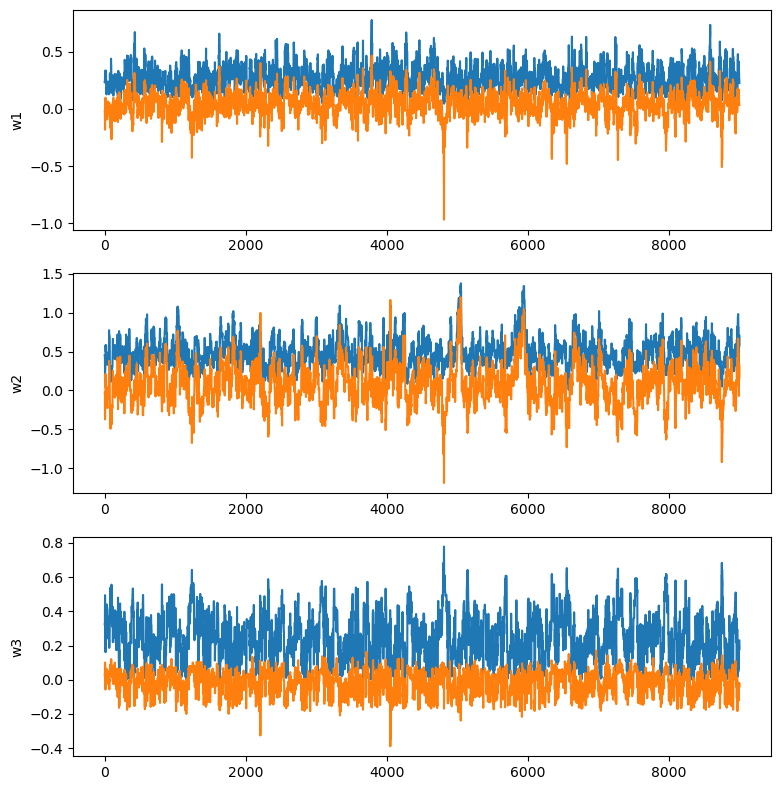

In [80]:

fig, axs = plt.subplots(3, 1, figsize=(8, 8))

axs[0].plot(range(9001), omega_nv_sim[:,0][1000:])
axs[0].plot(range(9001), omega_tilde_1ss[1000:])
axs[0].set_ylabel('w1')
axs[1].plot(range(9001), omega_nv_sim[:,1][1000:])
axs[1].plot(range(9001), omega_tilde_2ss[1000:])
axs[1].set_ylabel('w2')
axs[2].plot(range(9001), omega_nv_sim[:,2][1000:])
axs[2].plot(range(9001), omega_tilde_3ss[1000:])
axs[2].set_ylabel('w3')
plt.tight_layout()
plt.show()

Pour les données réelles : 

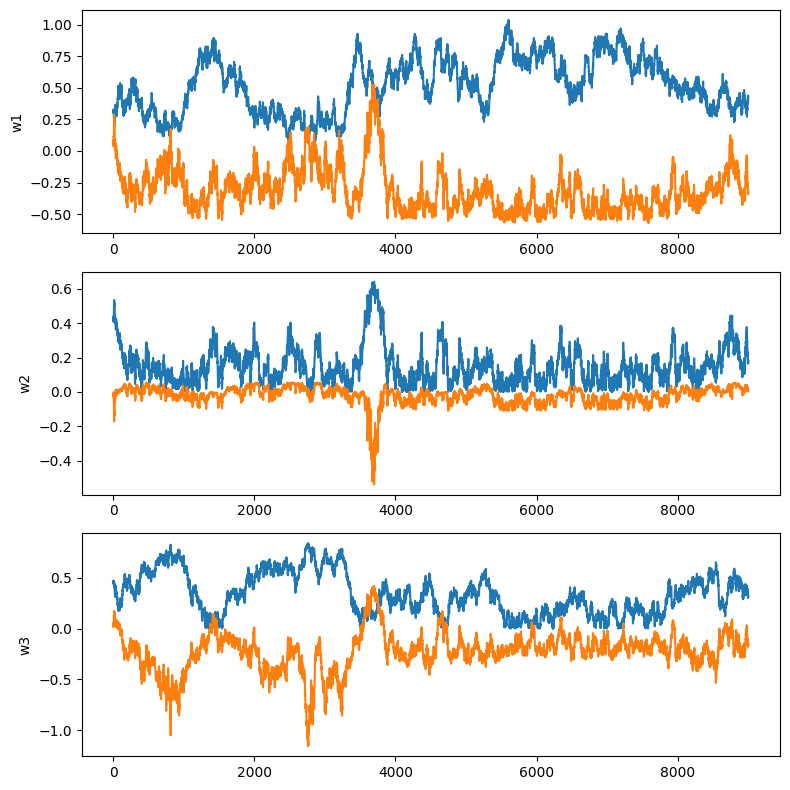

In [376]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

axs[0].plot(range(9001), omega_nv_reel[:,0][1000:])
axs[0].plot(range(9001), omega_tilde_1ss_reel[1000:])
axs[0].set_ylabel('w1')
axs[1].plot(range(9001), omega_nv_reel[:,1][1000:])
axs[1].plot(range(9001), omega_tilde_2ss_reel[1000:])
axs[1].set_ylabel('w2')
axs[2].plot(range(9001), omega_nv_reel[:,2][1000:])
axs[2].plot(range(9001), omega_tilde_3ss_reel[1000:])
axs[2].set_ylabel('w3')
plt.tight_layout()
plt.show()

## ZV-MCMC : Second Order Control Variates

In [72]:

def control_variates_2 (x,z):
    """
    Args:
        x (np.array): échantillon de paramètres (omega1, omega2, omega3)
        z (np.array): échantillon de variables de contrôle d'ordre 1 (z1,z2,z3)

    Returns:
        np.array: un échantillon de 9 variables de contrôle, ZV-MCMC d'ordre 2
    """
    i = np.ones(z.shape)
    u = z*x -0.5*i
    v1 = x[:,1]*z[:,0] + x[:,0]*z[:,1]
    v2 = x[:,2]*z[:,0] + x[:,0]*z[:,2]
    v3 = x[:,2]*z[:,1] + x[:,1]*z[:,2]
    v = np.column_stack((v1, v2, v3))
    vT = v.transpose()
    uT = u.transpose()
    zT = z.transpose()
    zTuTvT = np.concatenate((zT, uT, vT), axis = 0)

    # CV2 est un échantillon de même taille que x et z de 9-uplets ; Pour ZV-MCMC de degré 2 on a 9 variables de contrôles
    # Une colonne de CV2 est une variable de contôle 
    CV2 = zTuTvT.transpose()

    return CV2


First stage : Une première régression pour chaque paramètre omega_i pour déterminer les coefficients optimaux de chacune des 9 variables de contrôle.

In [76]:
def opti_coeff_CV2 (omega, CV2):
    d = dict() 
    # d est un dictionnaire qui stocke les coefficients optimaux des variables de contrôle de chacun des omega1, omega2 et omega3
    for i in [0,1,2]:
        model = LinearRegression()
        model.fit(CV2, omega[:,i])
        d['omega' + str(i+1)] = model.coef_
    return d

# Pour les données simulées
omega = metropolis (y, omega_current, n_iter, var, c_opt_sim)[1]
z = calcul_z(omega[:,0], omega[:,1], omega[:,2], h, y, var[0])
CV2_sim = control_variates_2 (omega,z)

# Pour les données réelles; COMMENT TROUVER LE H DES DONNEES REELLES !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# omega = metropolis (r, omega_current, n_iter, var, c_opt_reel)[1]
# z = calcul_z(omega[:,0], omega[:,1], omega[:,2], h, r, sigma)
# CV2_reel = control_variates_2 (omega,z)


KeyboardInterrupt: 

## Approche naïve : une seule régression

Second stage : génération des échantillons omega_tilde 

Maintenant qu'on a récupéré les coefficients optimaux des variables de contrôle avec une régression linéaire, nous générons un échantillon omega1_tilde, omega2_tilde et omega3_tilde tel que : 

    omegai_tilde = omega_i + la combinaison linéaire des variables de contrôle pondérées par les coefficients trouvés par la régression.
Cette combinaison est exactement la prédiction du modèle.

In [ ]:
def omega_tilde(omega, i, CV2, d):
    CV = CV2.copy()
    for k in range(9) :
        CV[:,k] = CV[:,k] * d['omega' + str(i)][k]
return omega[:,i] + np.sum(CV, axis = 1)

In [ ]:
d_sim = opti_coeff_CV2 (omega, CV2_sim)
omega_tilde_sim = omega_tilde(omega, 1, CV2_sim, d_sim)

## Approche LASSO : CODE NON TESTE

In [ ]:
def cross_validation(X,Y,lambda):

    k = 10  # Nombre de plis
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Effectuer la validation croisée
    mse_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        lasso = Lasso(alpha=lambda)
        lasso.fit(X_train_scaled, y_train)
        predictions = lasso.predict(X_test_scaled)

        # Calculer l'erreur quadratique moyenne (MSE) des prédictions
        mse = mean_squared_error(y_test, predictions)
        mse_scores.append(mse)

    # Calculer la moyenne des scores MSE sur les plis
    average_mse = np.mean(mse_scores)
    
    return average_mse

def lambda_etoile (X,Y):
    MSE = []
    LAM  = np.linspace(-100,100,1000) 
    for lambda in LAM :
        MSE.append(cross_validation(X,Y,lambda))
    i = MSE.index(MSE.min())
    return LAM[i]

def beta_LASSO (X,Y, lambda) :
    lasso = Lasso(alpha=lambda)
    lasso.fit(X, Y)
retrun lasso.coef_


def reg_penal(X,Y,beta_LASSO):
    var = []
    
    for i in len(beta_LASSO) :
        if beta_LASSO[i] != 0 :
            var.append(i)

    model = LinearRegression()
    model.fit(X[:,var], Y)

    return Y +  model.predict(X) # nos omega_tilde
